### Feature selection

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, f_classif, RFE
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import mutual_info_score
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
import warnings
warnings.filterwarnings('ignore')

In [41]:
from sklearn.pipeline import FunctionTransformer

In [3]:
# Load the engineered dataset
print("Loading engineered dataset...")
df = pd.read_csv('../data/loan_data_engineered.csv')
print(f"Dataset shape: {df.shape}")

Loading engineered dataset...
Dataset shape: (9578, 54)


In [4]:
df.head()

,credit.policy,purpose,int.rate,installment,log.annual.inc,dti,fico,days.with.cr.line,revol.bal,revol.util,...,annual_income,monthly_income,payment_to_income_ratio,inquiries_per_year,combined_risk_score,has_delinquency,has_public_record,high_inquiries,high_utilization,meets_credit_policy
0,1,debt_consolidation,0.1189,829.10,11.350407,19.48,737,5639.958333,28854,52.1,...,85000.000385,7083.333365,0.117049,0.000000,0.443624,0,0,0,0,1
1,1,credit_card,0.1071,228.22,11.082143,14.29,707,2760.000000,33623,76.7,...,65000.000073,5416.666673,0.042133,0.000000,0.481827,0,0,0,1,1
2,1,debt_consolidation,0.1357,366.86,10.373491,11.63,682,4710.000000,3511,25.6,...,31999.999943,2666.666662,0.137573,0.154989,0.505469,0,0,0,0,1
3,1,debt_consolidation,0.1008,162.34,11.350407,8.10,712,2699.958333,33667,73.2,...,85000.000385,7083.333365,0.022919,0.270375,0.425037,0,0,0,1,1
4,1,credit_card,0.1426,102.92,11.299732,14.97,667,4066.000000,4740,39.5,...,80799.999636,6733.333303,0.015285,0.000000,0.580854,1,0,0,0,1


In [5]:
print("\n1. Data cleaning and preparation...")

# Check for missing values
missing_values = df.isnull().sum()
print("\nMissing values in each column:")
print(missing_values[missing_values > 0])  # Only show columns with missing values


1. Data cleaning and preparation...

Missing values in each column:
dti_category    89
dtype: int64


In [6]:
df['dti_category'].head()

0    Medium DTI
1    Medium DTI
2    Medium DTI
3       Low DTI
4    Medium DTI
Name: dti_category, dtype: object

In [8]:
# get rid of missing values

df.dropna(subset=['dti_category'], inplace=True)

In [9]:
df.shape

(9489, 54)

In [11]:
# Remove duplicate rows if any
duplicate_count = df.duplicated().sum()
if duplicate_count > 0:
    df = df.drop_duplicates()
    print(f"Removed {duplicate_count} duplicate rows")
else:
    print("No duplicate rows found")


No duplicate rows found


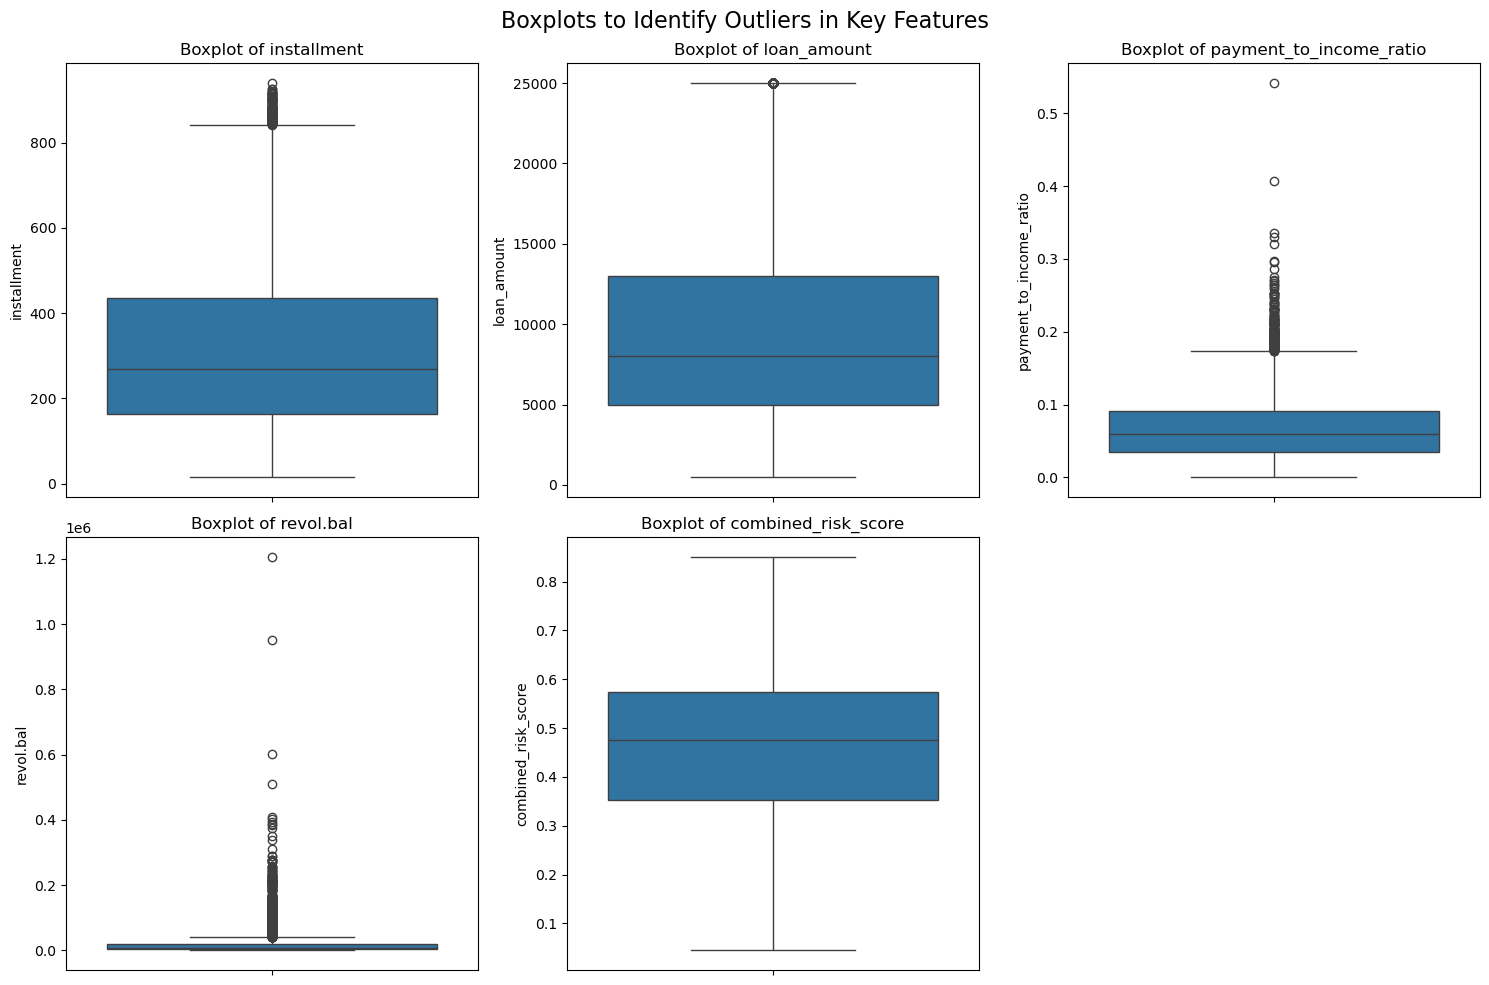

In [ ]:
# Check for outliers in key numeric columns using box plots
plt.figure(figsize=(15, 10))
plt.suptitle('Boxplots to Identify Outliers in Key Features', fontsize=16)

# Select columns to check for outliers
outlier_check_cols = ['installment', 'loan_amount', 'payment_to_income_ratio', 
                      'revol.bal', 'combined_risk_score']

for i, col in enumerate(outlier_check_cols):
    plt.subplot(2, 3, i+1)
    sns.boxplot(y=df[col])
    plt.title(f'Boxplot of {col}')
    plt.tight_layout()

plt.savefig('./figures/outlier_detection.png')
plt.show()

In [13]:
# Handle outliers for payment_to_income_ratio and other extreme values
# Using capping method (setting to 95th or 5th percentile)
for col in ['payment_to_income_ratio', 'loan_amount', 'revol.bal']:
    upper_limit = df[col].quantile(0.95)
    lower_limit = df[col].quantile(0.05)
    df[col] = df[col].clip(lower=lower_limit, upper=upper_limit)

print("\nOutliers have been capped in key columns")


Outliers have been capped in key columns


In [17]:
df['revol_util_category'].head()

0    Medium
1      High
2       Low
3      High
4       Low
Name: revol_util_category, dtype: object

In [18]:
print("\n2. Feature selection...")

# Separate features and target
y = df['not.fully.paid']

# Remove non-feature columns and the target
non_feature_cols = ['not.fully.paid', 'fico_category', 'interest_tier', 'dti_category', 
                    'revol_util_category', 'credit_history_length', 'purpose']
X = df.drop(non_feature_cols, axis=1)

# Further select only numeric columns for initial analysis
numeric_cols = X.select_dtypes(include=['int64', 'float64']).columns
X_numeric = X[numeric_cols]

print(f"Number of potential features: {X_numeric.shape[1]}")



2. Feature selection...
Number of potential features: 27



Top 10 features by correlation with target:
                           Correlation
int.rate                      0.160828
credit.policy                 0.155990
meets_credit_policy           0.155990
combined_risk_score           0.155445
inq.last.6mths                0.150234
fico_interest_interaction     0.149218
fico                          0.148733
high_inquiries                0.136436
revol.util                    0.086564
inquiries_per_year            0.085889


<Figure size 1200x800 with 0 Axes>

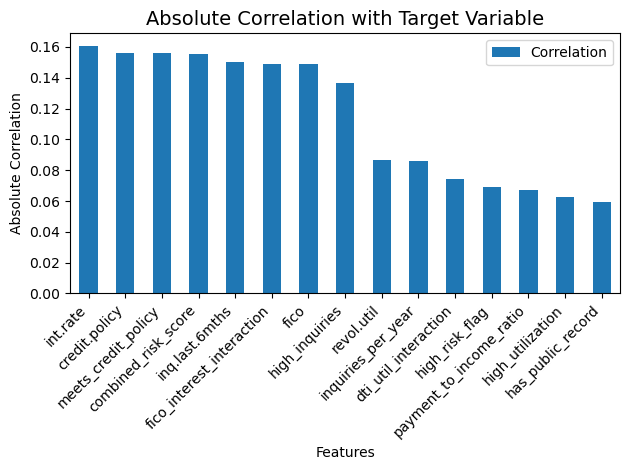

In [19]:
# Method 1: Correlation with the target variable
correlation_with_target = pd.DataFrame(
    X_numeric.corrwith(y).abs().sort_values(ascending=False),
    columns=['Correlation']
)
print("\nTop 10 features by correlation with target:")
print(correlation_with_target.head(10))

# Visualize feature correlations with target
plt.figure(figsize=(12, 8))
correlation_with_target.head(15).plot(kind='bar')
plt.title('Absolute Correlation with Target Variable', fontsize=14)
plt.ylabel('Absolute Correlation')
plt.xlabel('Features')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.savefig('./figures/correlation_with_target.png')
plt.show()


Calculating feature importance using Random Forest...

Top 10 features by Random Forest importance:
                      Feature  Importance
21        combined_risk_score    0.063947
14  fico_interest_interaction    0.061286
8                  revol.util    0.060942
7                   revol.bal    0.058750
19    payment_to_income_ratio    0.058261
4                         dti    0.058134
13               credit_years    0.057658
2                 installment    0.057504
15       dti_util_interaction    0.056517
6           days.with.cr.line    0.056138


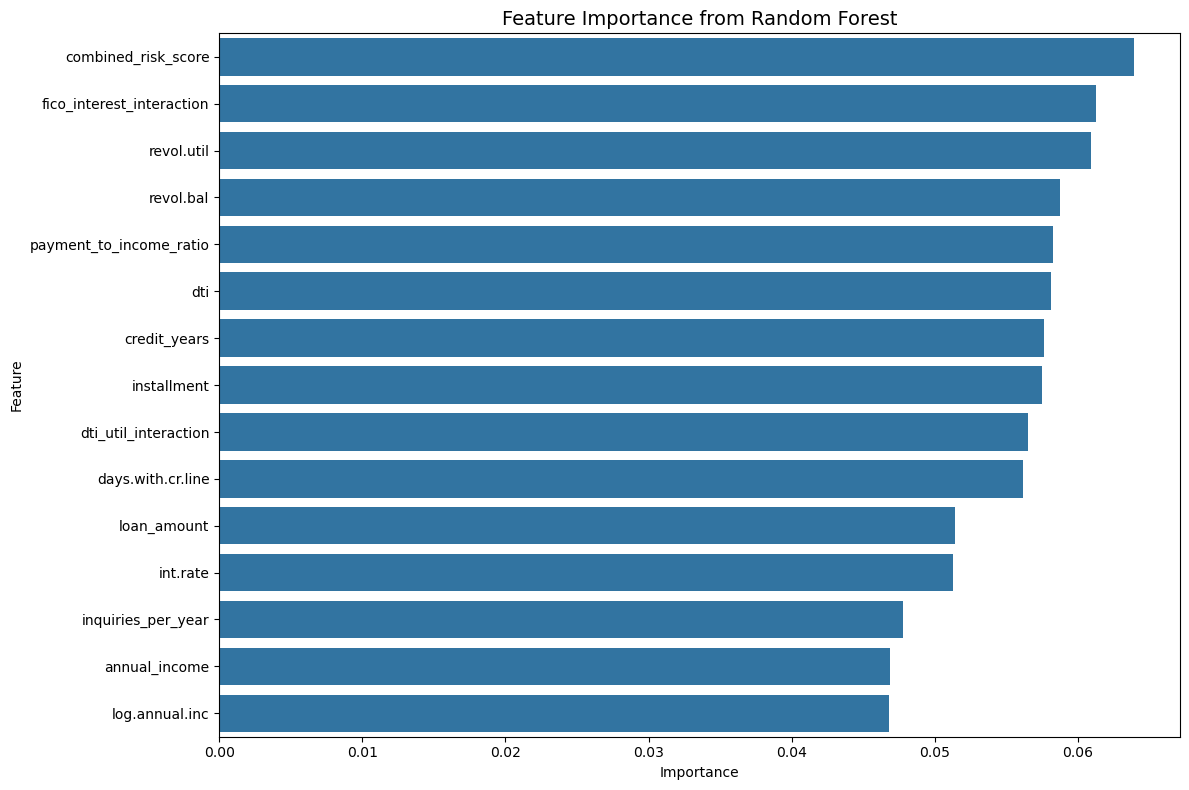

In [20]:
# method 2: feature importance from Random Forest

print("\nCalculating feature importance using Random Forest...")
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_numeric, y)
feature_importance = pd.DataFrame({
    'Feature': X_numeric.columns,
    'Importance': rf.feature_importances_
}).sort_values('Importance', ascending=False)

print("\nTop 10 features by Random Forest importance:")
print(feature_importance.head(10))

# Visualize feature importance
plt.figure(figsize=(12, 8))
sns.barplot(x='Importance', y='Feature', data=feature_importance.head(15))
plt.title('Feature Importance from Random Forest', fontsize=14)
plt.tight_layout()
plt.savefig('./figures/feature_importance_random_forest.png')
plt.show()


In [21]:
# Method 3: Statistical feature selection with ANOVA F-value
print("\nPerforming statistical feature selection with ANOVA F-value...")
selector = SelectKBest(score_func=f_classif, k=15)
selector.fit(X_numeric, y)
f_scores = pd.DataFrame({
    'Feature': X_numeric.columns,
    'F_Score': selector.scores_
}).sort_values('F_Score', ascending=False)

print("\nTop 10 features by ANOVA F-value:")
print(f_scores.head(10))


Performing statistical feature selection with ANOVA F-value...

Top 10 features by ANOVA F-value:
                      Feature     F_Score
1                    int.rate  251.902113
0               credit.policy  236.603917
26        meets_credit_policy  236.603917
21        combined_risk_score  234.913366
9              inq.last.6mths  219.069866
14  fico_interest_interaction  216.047074
5                        fico  214.614838
24             high_inquiries  179.947104
8                  revol.util   71.625462
20         inquiries_per_year   70.505425


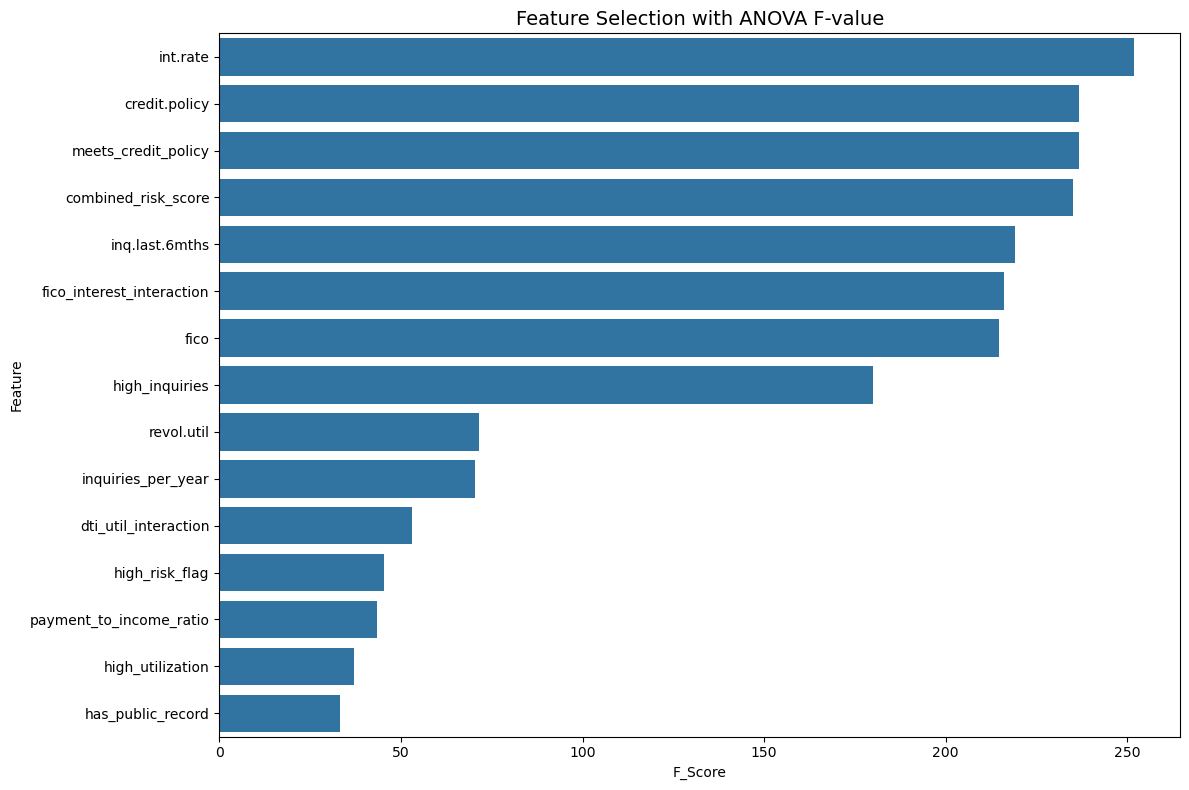

In [22]:
# Visualize f_scores
plt.figure(figsize=(12, 8))
sns.barplot(x='F_Score', y='Feature', data=f_scores.head(15))
plt.title('Feature Selection with ANOVA F-value', fontsize=14)
plt.tight_layout()
plt.savefig('./figures/f_scores.png')
plt.show()


In [23]:
# Combine all methods to select the best features
# Get top 20 features from each method
top_correlation = set(correlation_with_target.head(20).index)
top_importance = set(feature_importance.head(20)['Feature'])
top_f_score = set(f_scores.head(20)['Feature'])


In [24]:
# Find features that appear in at least 2 of the methods
common_features = set()
for feature in X_numeric.columns:
    count = 0
    if feature in top_correlation:
        count += 1
    if feature in top_importance:
        count += 1
    if feature in top_f_score:
        count += 1
    
    if count >= 2:
        common_features.add(feature)


In [25]:
common_features

{'combined_risk_score',
 'credit.policy',
 'dti',
 'dti_util_interaction',
 'fico',
 'fico_interest_interaction',
 'has_public_record',
 'high_inquiries',
 'high_risk_flag',
 'high_utilization',
 'inq.last.6mths',
 'inquiries_per_year',
 'installment',
 'int.rate',
 'loan_amount',
 'meets_credit_policy',
 'payment_to_income_ratio',
 'pub.rec',
 'revol.bal',
 'revol.util'}

In [27]:
# Add in one-hot encoded categorical features we want to keep
categorical_features = [col for col in X.columns if col.startswith(('purpose_', 'fico_cat_', 'int_tier_', 'dti_cat_'))]
selected_features = list(common_features) + categorical_features

print(f"\nSelected {len(selected_features)} features for modeling:")
print(selected_features)

# Create a dataframe with only selected features
X_selected = X[selected_features]



Selected 31 features for modeling:
['dti', 'combined_risk_score', 'installment', 'revol.util', 'fico_interest_interaction', 'fico', 'payment_to_income_ratio', 'inquiries_per_year', 'high_utilization', 'meets_credit_policy', 'high_inquiries', 'credit.policy', 'high_risk_flag', 'has_public_record', 'loan_amount', 'pub.rec', 'revol.bal', 'inq.last.6mths', 'dti_util_interaction', 'int.rate', 'fico_cat_Poor', 'fico_cat_Fair', 'fico_cat_Good', 'fico_cat_Excellent', 'int_tier_Low', 'int_tier_Medium', 'int_tier_High', 'int_tier_Very High', 'dti_cat_Low DTI', 'dti_cat_Medium DTI', 'dti_cat_High DTI']


In [28]:
X_selected.head()

,dti,combined_risk_score,installment,revol.util,fico_interest_interaction,fico,payment_to_income_ratio,inquiries_per_year,high_utilization,meets_credit_policy,...,fico_cat_Fair,fico_cat_Good,fico_cat_Excellent,int_tier_Low,int_tier_Medium,int_tier_High,int_tier_Very High,dti_cat_Low DTI,dti_cat_Medium DTI,dti_cat_High DTI
0,19.48,0.443624,829.10,52.1,87.6293,737,0.117049,0.000000,0,1,...,False,True,False,False,True,False,False,False,True,False
1,14.29,0.481827,228.22,76.7,75.7197,707,0.042133,0.000000,1,1,...,False,True,False,False,True,False,False,False,True,False
2,11.63,0.505469,366.86,25.6,92.5474,682,0.137573,0.154989,0,1,...,True,False,False,False,False,True,False,False,True,False
3,8.10,0.425037,162.34,73.2,71.7696,712,0.022919,0.270375,1,1,...,False,True,False,False,True,False,False,True,False,False
4,14.97,0.580854,102.92,39.5,95.1142,667,0.015285,0.000000,0,1,...,True,False,False,False,False,True,False,False,True,False


In [33]:

print("\n3. Checking for multicollinearity...")

# Calculate correlation matrix
correlation_matrix = X_selected.select_dtypes(include=['int64', 'float64']).corr()
#print(correlation_matrix.head())

# Identify highly correlated pairs
high_correlation_list = []

for i in range(len(correlation_matrix.columns)):
    for j in range(i+1, len(correlation_matrix.columns)):
        corr_value = correlation_matrix.iloc[i, j]
        if abs(corr_value) > 0.7:  # Threshold for high correlation
            high_correlation_list.append({
                'Feature1': correlation_matrix.columns[i],
                'Feature2': correlation_matrix.columns[j],
                'Correlation': corr_value
            })
high_correlation_df = pd.DataFrame(high_correlation_list)

correlation_matrix.head()
#print("\nHighly correlated features:", high_correlation_df)


3. Checking for multicollinearity...


,dti,combined_risk_score,installment,revol.util,fico_interest_interaction,fico,payment_to_income_ratio,inquiries_per_year,high_utilization,meets_credit_policy,high_inquiries,credit.policy,high_risk_flag,has_public_record,loan_amount,pub.rec,revol.bal,inq.last.6mths,dti_util_interaction,int.rate
dti,1.000000,0.491178,0.043940,0.321638,0.191997,-0.237556,0.097353,-0.047428,0.206846,-0.094162,0.022370,-0.094162,0.514010,0.008572,0.035616,0.003674,0.306058,0.028920,0.736694,0.217032
combined_risk_score,0.491178,1.000000,0.082555,0.730952,0.744852,-0.900661,0.101034,0.110305,0.536640,-0.312284,0.134478,-0.312284,0.544055,0.120903,0.038539,0.119222,0.228638,0.160674,0.708146,0.841233
installment,0.043940,0.082555,1.000000,0.076931,0.357396,0.087198,0.545757,-0.065985,0.056495,0.058487,-0.001368,0.058487,0.004329,-0.031473,0.993816,-0.033138,0.314251,-0.012198,0.079143,0.276622
revol.util,0.321638,0.730952,0.076931,1.000000,0.403384,-0.544172,0.050952,-0.023675,0.770088,-0.107688,-0.008737,-0.107688,0.318775,0.070348,0.055804,0.065715,0.367257,-0.013978,0.791274,0.466608
fico_interest_interaction,0.191997,0.744852,0.357396,0.403384,1.000000,-0.569721,0.227436,0.094745,0.335768,-0.245240,0.185031,-0.245240,0.360262,0.074388,0.305138,0.074319,0.139835,0.188434,0.365570,0.980071



Highly correlated feature pairs:
                     Feature1                   Feature2  Correlation
11        meets_credit_policy              credit.policy     1.000000
6                 installment                loan_amount     0.993816
9   fico_interest_interaction                   int.rate     0.980071
13          has_public_record                    pub.rec     0.951829
5         combined_risk_score                   int.rate     0.841233
8                  revol.util       dti_util_interaction     0.791274
7                  revol.util           high_utilization     0.770088
12             high_inquiries             inq.last.6mths     0.757384
2         combined_risk_score  fico_interest_interaction     0.744852
0                         dti       dti_util_interaction     0.736694
1         combined_risk_score                 revol.util     0.730952
4         combined_risk_score       dti_util_interaction     0.708146
10                       fico                   int.rate

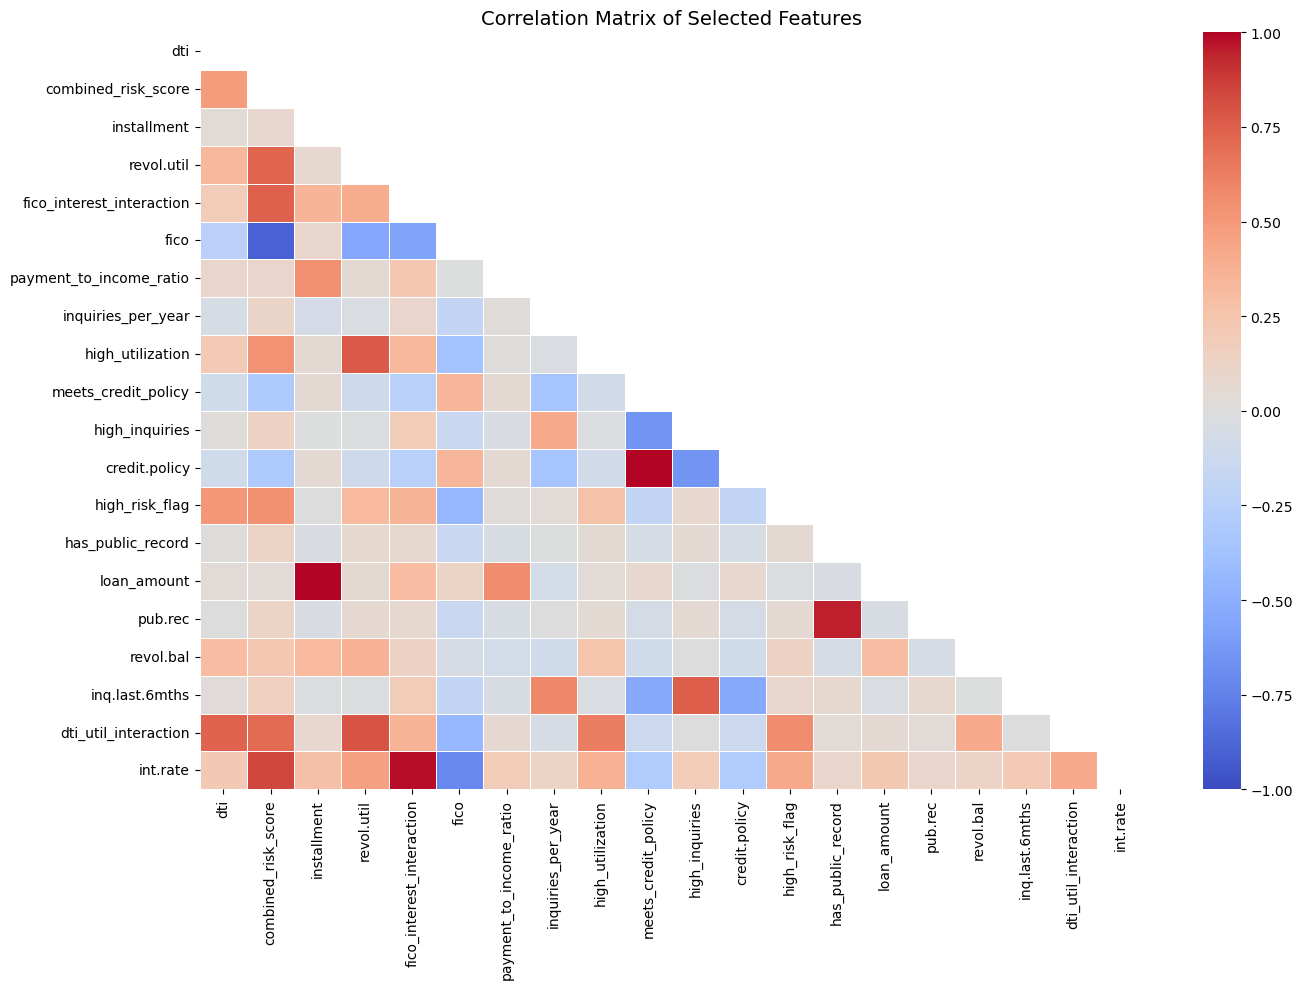


Removing 11 features due to high multicollinearity:
['dti', 'high_inquiries', 'credit.policy', 'dti_util_interaction', 'combined_risk_score', 'fico', 'revol.util', 'high_utilization', 'fico_interest_interaction', 'pub.rec', 'loan_amount']
Features after removing multicollinearity: 20


In [35]:
if len(high_correlation_df) > 0:
    print("\nHighly correlated feature pairs:")
    print(high_correlation_df.sort_values('Correlation', ascending=False))

    # Visualize the correlation matrix
    plt.figure(figsize=(14, 10))
    mask = np.triu(np.ones_like(correlation_matrix, dtype=bool))
    sns.heatmap(correlation_matrix, mask=mask, annot=False, cmap='coolwarm', 
                linewidths=0.5, vmin=-1, vmax=1)
    plt.title('Correlation Matrix of Selected Features', fontsize=14)
    plt.tight_layout()
    plt.savefig('./figures/correlation_matrix.png')
    plt.show()

    # For highly correlated pairs, keep the one with higher correlation with the target
    features_to_remove = []
    for _, row in high_correlation_df.iterrows():
        feat1, feat2 = row['Feature1'], row['Feature2']
        corr1 = abs(correlation_with_target.loc[feat1].values[0]) if feat1 in correlation_with_target.index else 0
        corr2 = abs(correlation_with_target.loc[feat2].values[0]) if feat2 in correlation_with_target.index else 0
        
        if corr1 < corr2:
            features_to_remove.append(feat1)
        else:
            features_to_remove.append(feat2)
    
    features_to_remove = list(set(features_to_remove))  # Remove duplicates
    print(f"\nRemoving {len(features_to_remove)} features due to high multicollinearity:")
    print(features_to_remove)
    
    # Remove highly correlated features
    X_selected = X_selected.drop(features_to_remove, axis=1)
    print(f"Features after removing multicollinearity: {X_selected.shape[1]}")
else:
    print("No high multicollinearity detected among selected features")

In [36]:
print("\n4. Data preprocessing...")

# Split into train and test sets
X_train, X_test, y_train, y_test = train_test_split(
    X_selected, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Training set: {X_train.shape[0]} samples")
print(f"Testing set: {X_test.shape[0]} samples")


4. Data preprocessing...
Training set: 7591 samples
Testing set: 1898 samples


In [37]:
# Check class imbalance
class_counts = y.value_counts()
imbalance_ratio = class_counts[0] / class_counts[1]
print(f"\nClass distribution in full dataset:")
print(f"Class 0 (fully paid): {class_counts[0]} ({class_counts[0]/len(y)*100:.1f}%)")
print(f"Class 1 (not fully paid): {class_counts[1]} ({class_counts[1]/len(y)*100:.1f}%)")
print(f"Imbalance ratio: {imbalance_ratio:.2f}:1")



Class distribution in full dataset:
Class 0 (fully paid): 7977 (84.1%)
Class 1 (not fully paid): 1512 (15.9%)
Imbalance ratio: 5.28:1


In [38]:
# Check class distribution in train and test sets
print(f"\nClass distribution in training set:")
print(pd.Series(y_train).value_counts(normalize=True) * 100)
print(f"\nClass distribution in testing set:")
print(pd.Series(y_test).value_counts(normalize=True) * 100)


Class distribution in training set:
not.fully.paid
0    84.060071
1    15.939929
Name: proportion, dtype: float64

Class distribution in testing set:
not.fully.paid
0    84.088514
1    15.911486
Name: proportion, dtype: float64


In [ ]:
# Identify numeric and categorical columns
numeric_features = X_selected.select_dtypes(include=['int64', 'float64']).columns.tolist()
categorical_features = X_selected.select_dtypes(exclude=['int64', 'float64']).columns.tolist()
boolean_features = X_selected.select_dtypes(include=['bool']).columns.tolist()


print(f"\nNumeric features: {len(numeric_features)}")
print(f"Categorical features: {len(categorical_features)}")
print(f"Boolean features: {len(boolean_features)}")

# Create preprocessing pipelines
numeric_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='median')),
    ('scaler', StandardScaler())
])

#categorical_transformer = Pipeline(steps=[
#    ('imputer', SimpleImputer(strategy='constant', fill_value='missing'))
#])

# Add a boolean transformer (convert to int)
boolean_transformer = Pipeline(steps=[
    ('bool_to_int', FunctionTransformer(lambda x: x.astype(int))),
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('scaler', StandardScaler())
])


Numeric features: 9
Categorical features: 11
Boolean features: 11


In [43]:
print(boolean_features)
print(categorical_features)

['fico_cat_Poor', 'fico_cat_Fair', 'fico_cat_Good', 'fico_cat_Excellent', 'int_tier_Low', 'int_tier_Medium', 'int_tier_High', 'int_tier_Very High', 'dti_cat_Low DTI', 'dti_cat_Medium DTI', 'dti_cat_High DTI']
['fico_cat_Poor', 'fico_cat_Fair', 'fico_cat_Good', 'fico_cat_Excellent', 'int_tier_Low', 'int_tier_Medium', 'int_tier_High', 'int_tier_Very High', 'dti_cat_Low DTI', 'dti_cat_Medium DTI', 'dti_cat_High DTI']


In [45]:
X_selected.dtypes.unique()

array([dtype('float64'), dtype('int64'), dtype('bool')], dtype=object)

In [46]:
# Combine preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, numeric_features),
        ('cat', boolean_transformer, boolean_features)
    ])

# Apply preprocessing to the training data
print("\nApplying preprocessing transformations...")
X_train_processed = preprocessor.fit_transform(X_train)
X_test_processed = preprocessor.transform(X_test)

print(f"Processed training data shape: {X_train_processed.shape}")
print(f"Processed testing data shape: {X_test_processed.shape}")



Applying preprocessing transformations...
Processed training data shape: (7591, 20)
Processed testing data shape: (1898, 20)


In [47]:
imbalance_ratio

5.275793650793651

In [49]:
from imblearn.over_sampling import SMOTE

In [50]:
print("\n5. Handling class imbalance...")

# Check for imbalance
if imbalance_ratio > 3:
    print(f"Dataset is imbalanced with a ratio of {imbalance_ratio:.2f}:1")
    print("Applying SMOTE for oversampling the minority class...")
    
    
    smote = SMOTE(random_state=42)
    X_train_resampled, y_train_resampled = smote.fit_resample(X_train_processed, y_train)
    
    print(f"Original training data shape: {X_train_processed.shape}")
    print(f"Resampled training data shape: {X_train_resampled.shape}")
    
    # Check new class distribution
    print("\nClass distribution after SMOTE:")
    print(pd.Series(y_train_resampled).value_counts(normalize=True) * 100)
    
    # Update training data
    X_train_processed = X_train_resampled
    y_train = y_train_resampled
else:
    print("Class imbalance is relatively moderate. SMOTE not applied.")


5. Handling class imbalance...
Dataset is imbalanced with a ratio of 5.28:1
Applying SMOTE for oversampling the minority class...
Original training data shape: (7591, 20)
Resampled training data shape: (12762, 20)

Class distribution after SMOTE:
not.fully.paid
0    50.0
1    50.0
Name: proportion, dtype: float64


In [52]:
# Save the names of features in order of preprocessor
with open('../data/selected_features.txt', 'w') as f:
    for feature in X_selected.columns:
        f.write(f"{feature}\n")

# Save processed datasets (convert to DataFrame first for better handling)
np.save('../data/X_train_processed.npy', X_train_processed)
np.save('../data/X_test_processed.npy', X_test_processed)
np.save('../data/y_train.npy', y_train)
np.save('../data/y_test.npy', y_test)

import dill
dill.dump(preprocessor, open('preprocessor.pkl', 'wb'))

In [53]:

print("\nProcessed datasets and preprocessor saved successfully!")
print("Next step: Model Building and Evaluation")



Processed datasets and preprocessor saved successfully!
Next step: Model Building and Evaluation


In [54]:
# Print summary of feature selection and preprocessing
print("\n===== Feature Selection and Preprocessing Summary =====")
print(f"Original number of features: {df.shape[1]}")
print(f"Selected features for modeling: {X_selected.shape[1]}")
print(f"Training samples: {X_train_processed.shape[0]}")
print(f"Testing samples: {X_test_processed.shape[0]}")
print("Feature selection methods used: Correlation, Random Forest Importance, ANOVA F-value")
print("Preprocessing steps: Outlier handling, Scaling, Missing value imputation")

if imbalance_ratio > 3:
    print("Class imbalance handled using SMOTE")
else:
    print("Class imbalance moderate - no special handling applied")

print("\nFiles saved:")
print("- selected_features.txt: List of selected features")
print("- X_train_processed.npy: Processed training features")
print("- X_test_processed.npy: Processed test features")
print("- y_train.npy: Training target values")
print("- y_test.npy: Test target values")
print("- preprocessor.pkl: Fitted preprocessor for future data transformation")
print("- Visualization plots saved as PNG files")


===== Feature Selection and Preprocessing Summary =====
Original number of features: 54
Selected features for modeling: 20
Training samples: 12762
Testing samples: 1898
Feature selection methods used: Correlation, Random Forest Importance, ANOVA F-value
Preprocessing steps: Outlier handling, Scaling, Missing value imputation
Class imbalance handled using SMOTE

Files saved:
- selected_features.txt: List of selected features
- X_train_processed.npy: Processed training features
- X_test_processed.npy: Processed test features
- y_train.npy: Training target values
- y_test.npy: Test target values
- preprocessor.pkl: Fitted preprocessor for future data transformation
- Visualization plots saved as PNG files
